In [1]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import ticker
import cartopy.crs as ccrs
import numpy as np

plt.rcParams["figure.figsize"] = (20, 20)
plt.rcParams["figure.facecolor"] = "white"

BASE_PATH = Path("~/data/prepared_ML_training_data/v15/train").expanduser()
PV_PATH = BASE_PATH / "pv"
HRV_PATH = BASE_PATH / "hrvsatellite"
BATCH = "000001.nc"

In [2]:
hrv_batch = xr.open_dataset(HRV_PATH / BATCH)
pv_batch = xr.open_dataset(PV_PATH / BATCH)

In [3]:
hrv_batch

<xarray.Dataset>
Dimensions:                (example: 32, channels_index: 1, time_index: 31,
                            y_geostationary_index: 64, x_geostationary_index: 64)
Coordinates:
  * channels_index         (channels_index) int64 0
  * example                (example) int64 0 1 2 3 4 5 6 ... 26 27 28 29 30 31
  * time_index             (time_index) int64 0 1 2 3 4 5 ... 25 26 27 28 29 30
  * x_geostationary_index  (x_geostationary_index) int64 0 1 2 3 ... 60 61 62 63
    x_osgb                 (example, y_geostationary_index, x_geostationary_index) float32 ...
  * y_geostationary_index  (y_geostationary_index) int64 0 1 2 3 ... 60 61 62 63
    y_osgb                 (example, y_geostationary_index, x_geostationary_index) float32 ...
Data variables:
    channels               (example, channels_index) object ...
    data                   (example, time_index, y_geostationary_index, x_geostationary_index, channels_index) int16 ...
    time                   (example, time_index) datetime64[ns] ...
    x_geostationary        (example, x_geostationary_index) float32 ...
    y_geostationary        (example, y_geostationary_index) float32 ...

In [ ]:
hrv_batch["data"].sel(channels_index=0, example=1, time_index=0)

<xarray.DataArray 'data' (y_geostationary_index: 64, x_geostationary_index: 64)>
array([[142, 146, 148, ..., 242, 250, 266],
       [143, 148, 149, ..., 216, 228, 236],
       [143, 146, 150, ..., 194, 209, 223],
       ...,
       [149, 146, 146, ..., 187, 181, 172],
       [145, 148, 148, ..., 174, 168, 158],
       [155, 149, 146, ..., 156, 156, 150]], dtype=int16)
Coordinates:
    channels_index         int64 0
    example                int64 1
    time_index             int64 0
  * x_geostationary_index  (x_geostationary_index) int64 0 1 2 3 ... 60 61 62 63
    x_osgb                 (y_geostationary_index, x_geostationary_index) float32 ...
  * y_geostationary_index  (y_geostationary_index) int64 0 1 2 3 ... 60 61 62 63
    y_osgb                 (y_geostationary_index, x_geostationary_index) float32 ...

In [50]:
hrv_batch["x_osgb"].sel(example=EXAMPLE_I).isel(y_geostationary_index=[0, -1], x_geostationary_index=0).max()

<xarray.DataArray 'x_osgb' ()>
array(476826., dtype=float32)
Coordinates:
    example                int64 1
    x_geostationary_index  int64 0

Getting the OSGB boundaries for the PV systems is a bit fiddly because the satellite image is a skewed rectangle. We want the regular rectangle that fits within the OSGB boundaries:


```

skewed satellite image
\--------\
 \         \-------\
  \    |===========|\
   \   | selection | \
    \  |           |  \
     \ |===========|   \
      \--------\        \
                \--------\
```

And the skew angle and direction might vary (e.g. if we compare images from Italy vs UK). So, to find the minimum value for _x_, we find the left-most coordinate for the top and bottom rows satellite image, and find the _max_ (right-most) value of this pair of numbers.

In [85]:
EXAMPLE_I = 1

min_x_osgb = hrv_batch["x_osgb"].sel(example=EXAMPLE_I).isel(
    y_geostationary_index=[0, -1], 
    x_geostationary_index=0
    ).max().values + 10_000

max_x_osgb = hrv_batch["x_osgb"].sel(example=EXAMPLE_I).isel(
    y_geostationary_index=[0, -1], 
    x_geostationary_index=-1
    ).min().values - 10_000

min_y_osgb = hrv_batch["y_osgb"].sel(example=EXAMPLE_I).isel(
    y_geostationary_index=0, 
    x_geostationary_index=[0, -1]
    ).max().values + 57_000

max_y_osgb = hrv_batch["y_osgb"].sel(example=EXAMPLE_I).isel(
    y_geostationary_index=-1, 
    x_geostationary_index=[0, -1]
    ).min().values - 16_000

x_osgb_range = max_x_osgb - min_x_osgb
y_osgb_range = max_y_osgb - min_y_osgb
assert x_osgb_range > 0
assert y_osgb_range > 0

In [82]:
min_x_osgb, max_x_osgb, min_y_osgb, max_y_osgb, x_osgb_range, y_osgb_range

(486826.0, 512759.6875, 219439.953125, 277984.375, 25933.6875, 58544.421875)

In [83]:
pv_locations = pv_batch[["x_coords", "y_coords"]].sel(example=EXAMPLE_I)
valid_pv_id_mask = np.nonzero(pv_locations.x_coords.values)[0]
pv_locations = pv_locations.isel(id_index=valid_pv_id_mask)

pv_system_selection_mask = (
    (pv_locations.x_coords >= min_x_osgb) &
    (pv_locations.x_coords <= max_x_osgb) &
    (pv_locations.y_coords >= min_y_osgb) &
    (pv_locations.y_coords <= max_y_osgb)
)

selected_pv_locations = pv_locations.isel(id_index=pv_system_selection_mask)
selected_pv_locations

<xarray.Dataset>
Dimensions:   (id_index: 8)
Coordinates:
    example   int64 1
  * id_index  (id_index) int64 5 10 19 26 36 52 72 76
Data variables:
    x_coords  (id_index) float64 4.885e+05 4.871e+05 ... 5.071e+05 4.923e+05
    y_coords  (id_index) float64 2.394e+05 2.379e+05 ... 2.26e+05 2.657e+05

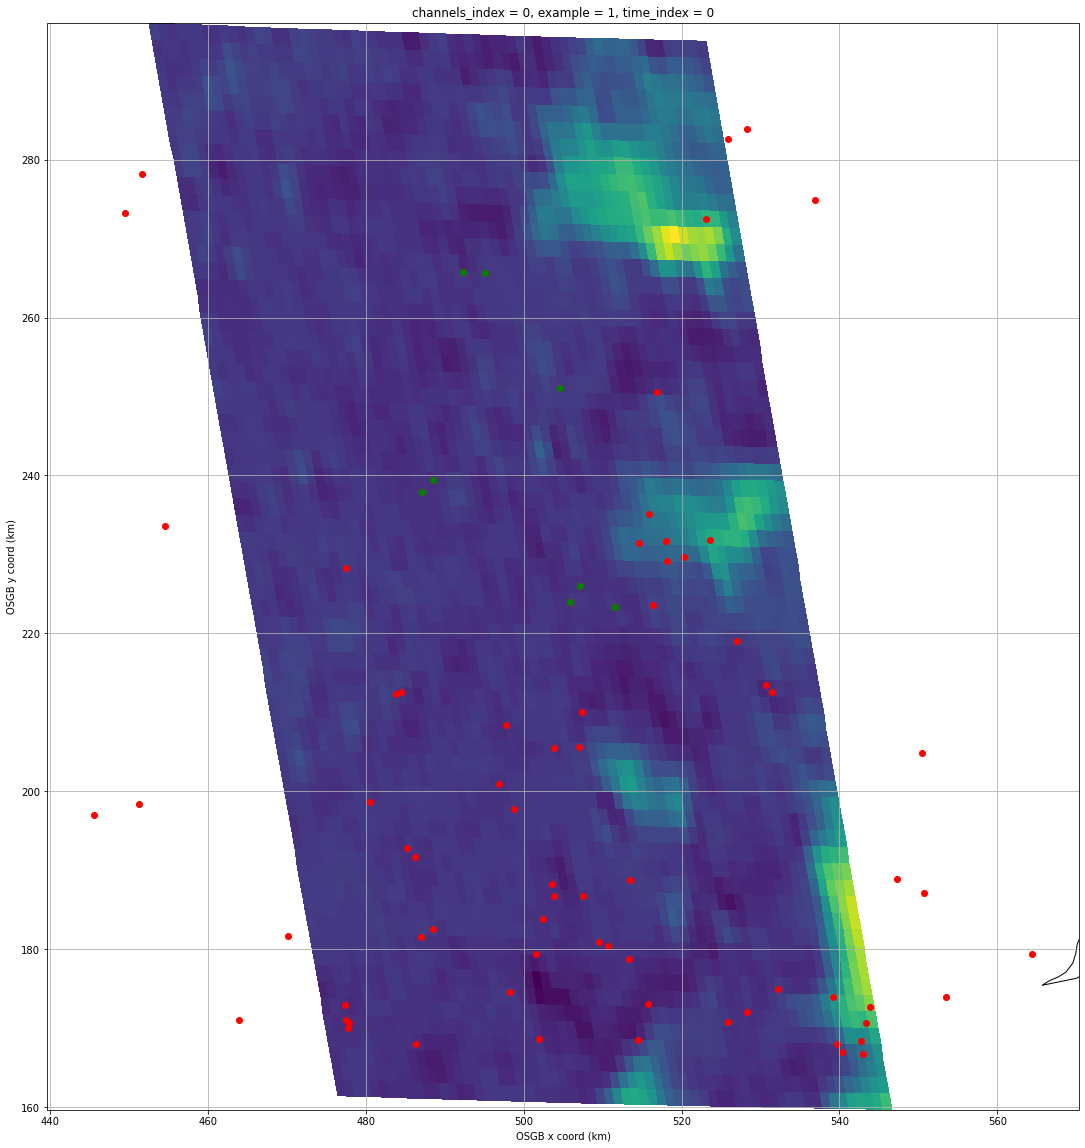

In [84]:
ax = plt.axes(projection=ccrs.OSGB(approx=False))

# Plot HRV
hrv_batch["data"].sel(channels_index=0, example=EXAMPLE_I, time_index=0).plot.pcolormesh(
    ax=ax,
    transform=ccrs.OSGB(approx=False),
    y="y_osgb",
    x="x_osgb",
    add_colorbar=False,
)

# Plot PV locations
ax.scatter(
    x=pv_locations.x_coords,
    y=pv_locations.y_coords,
    color="red"
)

ax.scatter(
    x=selected_pv_locations.x_coords,
    y=selected_pv_locations.y_coords,
    color="green",
)

ax.coastlines()
#ax.set_global()
for axis in (ax.xaxis, ax.yaxis):
    axis.set_visible(True)
    axis.set_major_formatter(ticker.FuncFormatter(lambda x, d: f"{x/1000:.0f}"))
ax.set_ylabel("OSGB y coord (km)")
ax.set_xlabel("OSGB x coord (km)")
ax.grid()

Select PV systems which are towards the upper-middle of the satellite imagery.

In [88]:
id_index_of_selected_pv_systems = selected_pv_locations.id_index
id_index_of_selected_pv_systems

<xarray.DataArray 'id_index' (id_index: 8)>
array([ 5, 10, 19, 26, 36, 52, 72, 76])
Coordinates:
    example   int64 1
  * id_index  (id_index) int64 5 10 19 26 36 52 72 76

In [91]:
pv_batch.sel(example=EXAMPLE_I).sel(id_index=id_index_of_selected_pv_systems)

<xarray.Dataset>
Dimensions:               (id_index: 8, time_index: 31)
Coordinates:
    example               int64 1
  * id_index              (id_index) int64 5 10 19 26 36 52 72 76
  * time_index            (time_index) int64 0 1 2 3 4 5 6 ... 25 26 27 28 29 30
Data variables:
    capacity_mwp          (id_index) float32 ...
    id                    (id_index) float64 ...
    power_mw              (time_index, id_index) float32 ...
    pv_system_row_number  (id_index) int64 ...
    time                  (time_index) datetime64[ns] ...
    x_coords              (id_index) float64 ...
    y_coords              (id_index) float64 ...